In [33]:
import collections
import importlib
from  janome.tokenizer import Tokenizer
import re
import pathlib
from py import my_module as mm
from pprint import pprint
from gensim import corpora, models
importlib.reload(mm)

from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.tokenfilter import ExtractAttributeFilter
from janome.tokenfilter import POSStopFilter
from janome.tokenfilter import POSKeepFilter

# 特徴語

文章の中に「京都よりも奈良に着目して」とあれば，その文書において奈良というのは重要な語であるが，京都はそうでない．

ここでは，奈良が京都よりも重要な語である，ということを抽出する方法を紹介

## 不要語

助詞のようにどの文章にある語，上述の文脈における「京都」といった語は文章の特徴を表さないことから，「不要語」と呼ばれる．
英語では**stop word**という. 

不要語の削除方法として，一番わかりやすいのが不要語のリストを作成しておくことである．
有名な日本語の不要語リストにはSlothLibがある．

また，特定の品詞を除外するということも有用である. 
以下ではその例を示す. 






In [3]:
string   = "京都と違う奈良の魅力"
stop_pos = ["助詞", "助動詞", "記号"]
analyzer = Analyzer(token_filters=[POSStopFilter(stop_pos), ExtractAttributeFilter("surface")])

print(list(analyzer.analyze(string)))





['京都', '違う', '奈良', '魅力']


逆に特定の品詞を抜き出すことも可能である. 

In [5]:

string   = "京都と違う奈良の魅力"
keep_pos = ["名詞"]
analyzer = Analyzer(token_filters=[POSKeepFilter(keep_pos), ExtractAttributeFilter("surface")])

print(list(analyzer.analyze(string)))


['京都', '奈良', '魅力']


走れメロスのデータに対して，名詞を抜き出し，ワードクラウドを作成する. 

In [8]:
melos = mm.get_string_from_file("irpb-files/data/ch01/melos.txt")
melos[:10]

'メロスは激怒した。必'

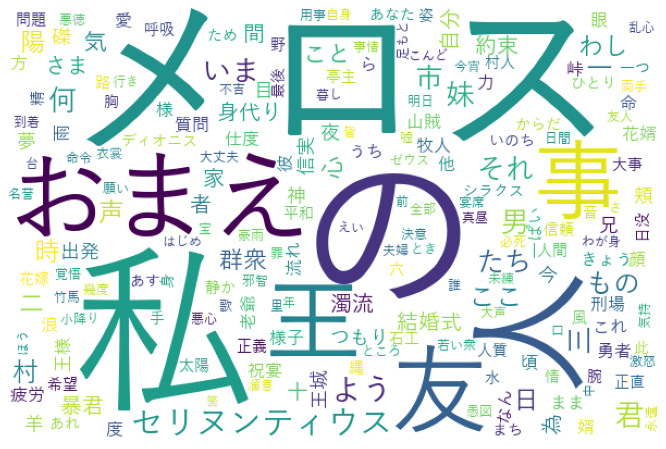

In [10]:
words = mm.get_words(melos, keep_pos = ["名詞"])
count = collections.Counter(words)
font  = mm.get_japanese_fonts()[0]
mm.create_word_cloud(count, font)

## TF・IDF

不要語を削除することで特徴語の抽出をおこなった．

ここでは特徴語の「特徴語らしさ」について定量化する方法を紹介する. 

文書`d`の特徴語`w`は次の条件を満たす必要があると考えられる. 

1. `w`が`d`に高頻度で出現する
2. `w`は特定の文書のみに出現する. 

前者は文書ごとに語の頻度を整理することでわかる. 

後者はコーパスと呼ばれるドキュメントの集合に対して，ある語が含まれるドキュメントの数の比率の逆数を取る．
比率の逆数のため，ある語が含まれるドキュメントが少ないほど，その語の特徴量としての性質がよいことになる. 

まとめると次の式になる．

$$
TF(d, w) \log_{2}\frac{|D|}{DF(\textrm{D}, w)}
$$




In [18]:
D     = pathlib.Path("irpb-files/data/ch03").glob("*.txt")
texts = [mm.get_string_from_file(x) for x in D]
pprint(texts, width = 40) 

['春は私の好きな季節だけど花粉が怖い',
 '私は梅も桜も好きで，特に桜の香りが好きだ']


In [19]:
docs = [mm.get_words(x, keep_pos = ["名詞"]) for x in texts]
pprint(docs, width = 40)




[['春', '私', '好き', '季節', '花粉'],
 ['私', '梅', '桜', '好き', '桜', '香り', '好き']]


In [21]:
# IDと文字列の対応を整理
dictionary = corpora.Dictionary(docs)
for k, v in dictionary.items():
    print(k, v)

0 好き
1 季節
2 春
3 私
4 花粉
5 桜
6 梅
7 香り


In [22]:
i = 2
s = "花粉"
print("ID = {}の語は「{}」".format(i, dictionary[i]))
print("「{}」のIDは{}".format(s, dictionary.token2id["花粉"]))

ID = 2の語は「春」
「花粉」のIDは4


`bow`というメソッドで単語の出現頻度を計算する. 

In [23]:
bows = [dictionary.doc2bow(d) for d in docs]

# 語の出現頻度とID
pprint(bows)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(0, 2), (3, 1), (5, 2), (6, 1), (7, 1)]]


In [25]:
from gensim import models

tfidf_model = models.TfidfModel(bows, normalize = False)
weights = tfidf_model[bows[1]]
print(weights)

[(5, 2.0), (6, 1.0), (7, 1.0)]


実際の文書は様々なものをある程度集める必要がある．

ここでは青空文庫のデータを使う. 

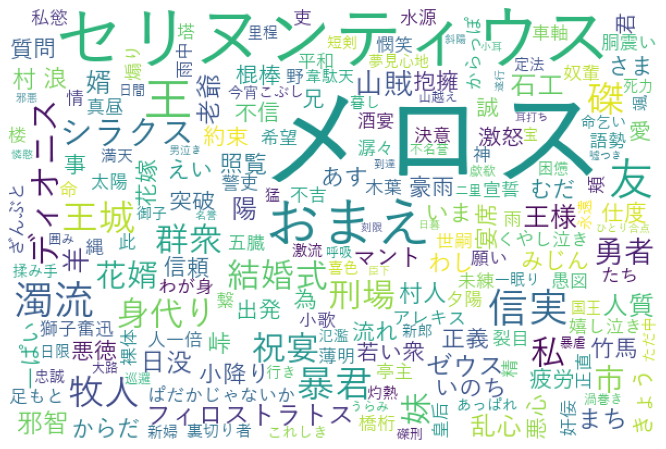

In [32]:
dic, bows = mm.load_aozora_corpus()

melos_text = mm.get_string_from_file("irpb-files/data/ch01/melos.txt")

dic, bows, melos_bows = mm.add_to_corpus([melos_text], dic, bows)

tfidf_model = models.TfidfModel(bows, normalize = True)

weights = mm.get_weights(melos_bows, dic, tfidf_model, surface = True)

count = dict(weights[0])

font  = mm.get_japanese_fonts()[0]
mm.create_word_cloud(count, font)
